In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/trained-commonlit-bert/Commonlit_bert_model.h5
/kaggle/input/commonlit-evaluate-student-summaries/sample_submission.csv
/kaggle/input/commonlit-evaluate-student-summaries/prompts_train.csv
/kaggle/input/commonlit-evaluate-student-summaries/summaries_test.csv
/kaggle/input/commonlit-evaluate-student-summaries/summaries_train.csv
/kaggle/input/commonlit-evaluate-student-summaries/prompts_test.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as py
import seaborn as sns
from sklearn.model_selection import train_test_split
from transformers import TFBertModel, TFAutoModel,BertConfig, BertTokenizerFast,BertModel
from tensorflow.keras.layers import Input, Dropout, Dense, GlobalAveragePooling1D,GlobalMaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.utils import to_categorical
import wandb
from wandb.keras import WandbCallback

#wandb.login()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
train_prompts = pd.read_csv('/kaggle/input/commonlit-evaluate-student-summaries/prompts_train.csv')
train_summary = pd.read_csv('/kaggle/input/commonlit-evaluate-student-summaries/summaries_train.csv')
test_summary = pd.read_csv('/kaggle/input/commonlit-evaluate-student-summaries/summaries_test.csv')

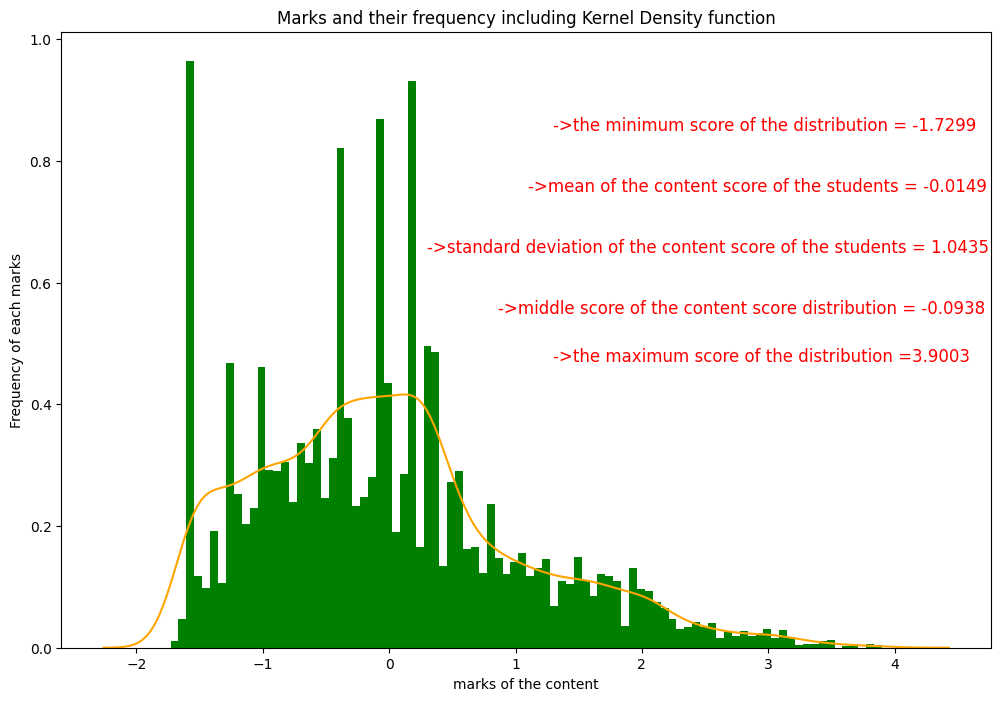

In [4]:
#Histogram 
py.subplots(figsize=(12,8))
py.hist(train_summary['content'],bins = 90,density = True,color='green')
sns.kdeplot(train_summary['content'], color='orange')
py.xlabel("marks of the content")
py.ylabel("Frequency of each marks")
py.title("Marks and their frequency including Kernel Density function")
py.text(1.30,0.85,f"->the minimum score of the distribution = {np.round(min(train_summary['content']),4)}",fontsize=12,color = 'red')
py.text(1.10,0.75,f"->mean of the content score of the students = {np.round(np.mean(train_summary['content']),4)}",fontsize=12,color = 'red')
py.text(0.30,0.65,f"->standard deviation of the content score of the students = {np.round(np.std(train_summary['content']),4)}",fontsize=12,color = 'red')
py.text(0.86,0.55,f"->middle score of the content score distribution = {np.round(np.median(train_summary['content']),4)}",fontsize=12,color = 'red')
py.text(1.30,0.47,f"->the maximum score of the distribution ={np.round(max(train_summary['content']),4)}",fontsize=12,color = 'red')
py.show()

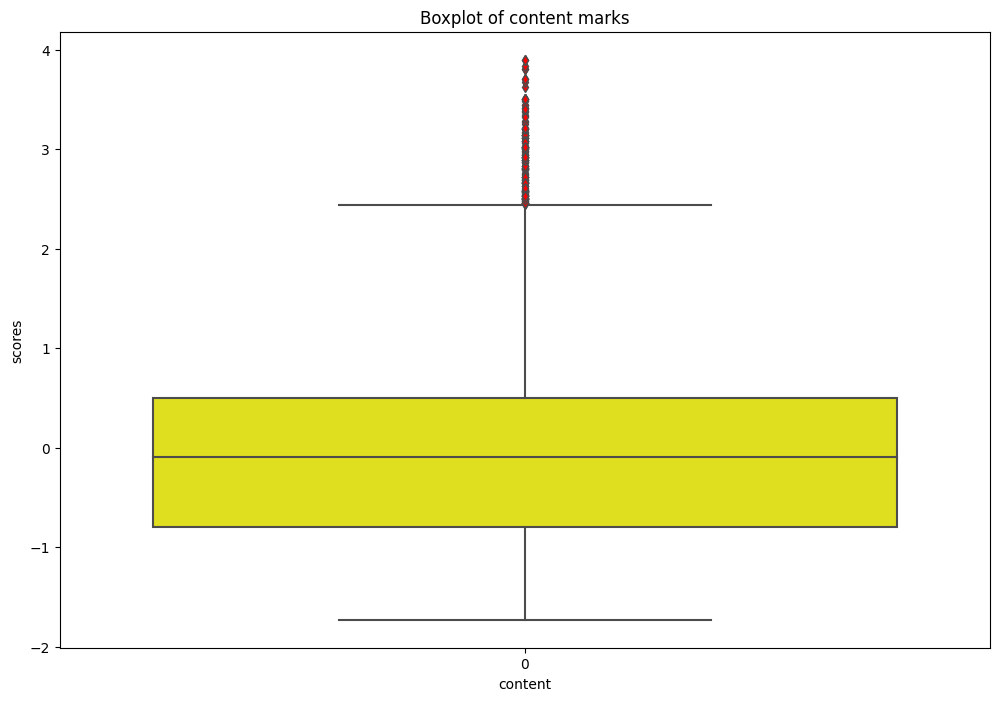

In [5]:
py.subplots(figsize=(12,8))
sns.boxplot(train_summary['content'],color='yellow', flierprops=dict(markerfacecolor='red'))
py.xlabel("content")
py.ylabel("scores")
py.title("Boxplot of content marks")
py.show()

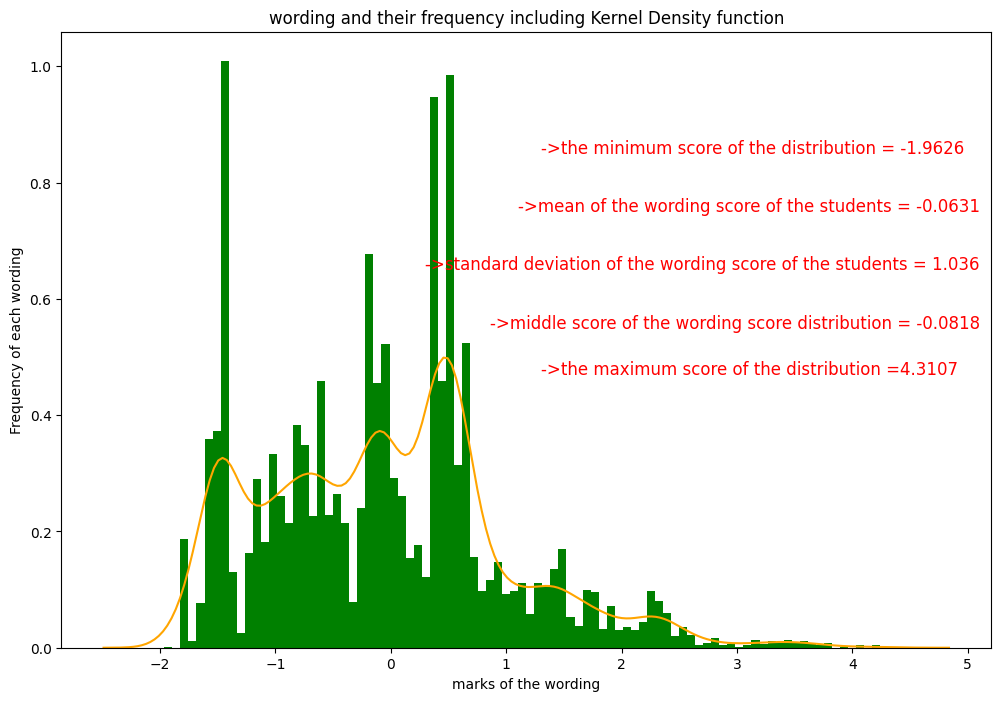

In [6]:

#Histogram 
py.subplots(figsize=(12,8))
py.hist(train_summary['wording'],bins = 90,density = True,color='green')
sns.kdeplot(train_summary['wording'], color='orange')
py.xlabel("marks of the wording")
py.ylabel("Frequency of each wording")
py.title("wording and their frequency including Kernel Density function")
py.text(1.30,0.85,f"->the minimum score of the distribution = {np.round(min(train_summary['wording']),4)}",fontsize=12,color = 'red')
py.text(1.10,0.75,f"->mean of the wording score of the students = {np.round(np.mean(train_summary['wording']),4)}",fontsize=12,color = 'red')
py.text(0.30,0.65,f"->standard deviation of the wording score of the students = {np.round(np.std(train_summary['wording']),4)}",fontsize=12,color = 'red')
py.text(0.86,0.55,f"->middle score of the wording score distribution = {np.round(np.median(train_summary['wording']),4)}",fontsize=12,color = 'red')
py.text(1.30,0.47,f"->the maximum score of the distribution ={np.round(max(train_summary['wording']),4)}",fontsize=12,color = 'red')
py.show()

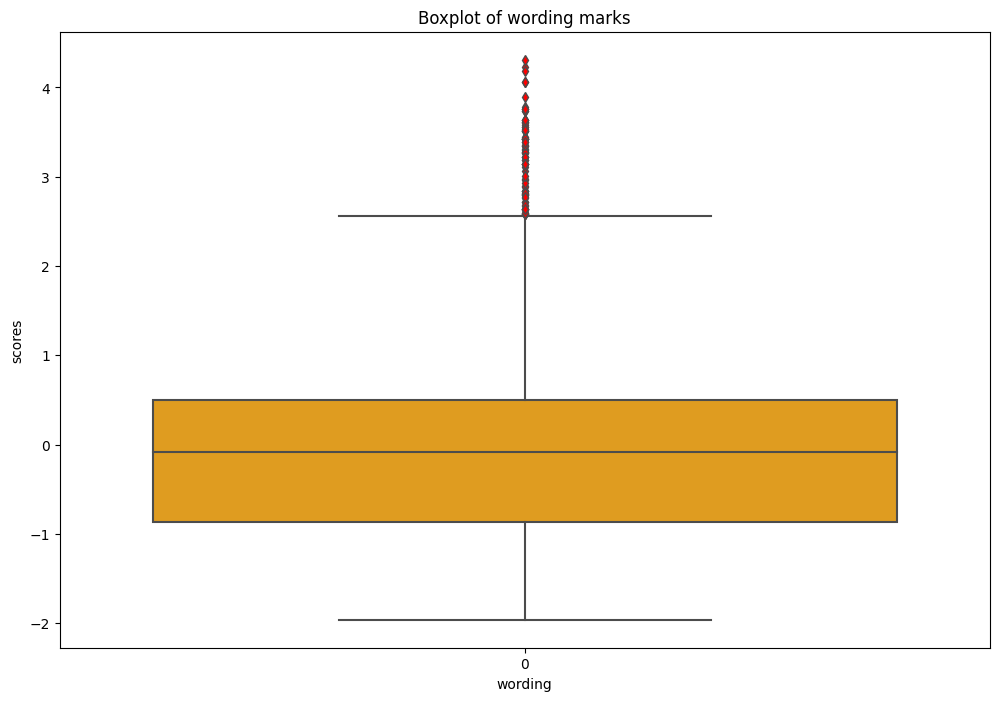

In [7]:
py.subplots(figsize=(12,8))
sns.boxplot(train_summary['wording'],color='orange', flierprops=dict(markerfacecolor='red'))
py.xlabel("wording")
py.ylabel("scores")
py.title("Boxplot of wording marks")
py.show()

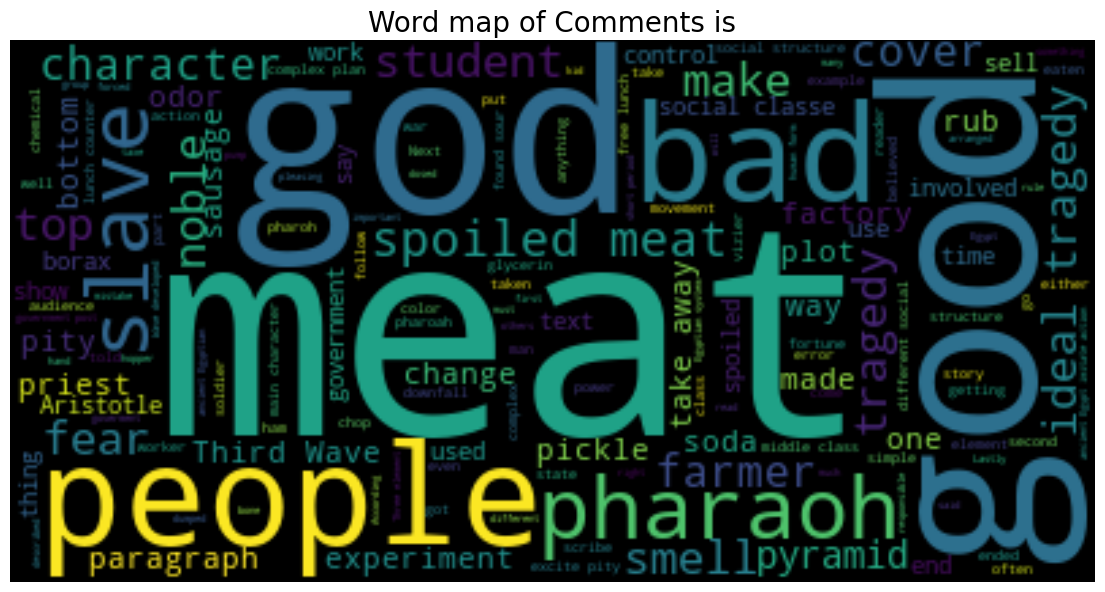

In [8]:
from wordcloud import WordCloud ,STOPWORDS
text = " ".join(i for i in train_summary.text)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords).generate(text)
print(wordcloud)
py.figure( figsize=(14,8))
py.imshow(wordcloud, interpolation='bilinear')
py.axis("off")
py.title("Word map of Comments is", fontsize=20)
py.show()
     

In [9]:
# We Shall Compare the Performances of Various Transformers BERT,RoBERTa, DISTILBERT and XLNet

In [10]:
train_useful = train_summary[['text','content','wording']]
train_useful = train_useful.sample(frac = 1.0)
x_train,x_val = train_test_split(train_useful,test_size=0.02,random_state=43)


In [11]:
config = BertConfig.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path='bert-base-uncased',config = config)
bert = TFAutoModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [12]:
!pip install --upgrade -q wandb

In [13]:
# l = []
# for i in train_summary['text'].values:
#     l.append(len(i))
#print(sum(l)//len(l)) - 418

In [14]:
ip_ids = Input(shape=(250,),name = 'input_ids',dtype = 'int32')
atts = Input(shape=(250,),name = 'attention_mask',dtype = 'int32')
final_ip = {'input_ids':ip_ids,'attention_mask':atts}

In [15]:
# Designing BERT Model
bert_first_layer = bert.bert(final_ip)
avg = GlobalAveragePooling1D()(bert_first_layer[0])
den = Dense(128,activation = 'relu')(avg)
drop = Dropout(0.25)(den)
op = Dense(2,activation='linear')(drop)
bert_model = Model(inputs = final_ip,outputs=op)
bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask (InputLayer)    [(None, 250)]        0           []                               
                                                                                                  
 input_ids (InputLayer)         [(None, 250)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  109482240   ['attention_mask[0][0]',         
                                thPoolingAndCrossAt               'input_ids[0][0]']              
                                tentions(last_hidde                                               
                                n_state=(None, 250,                                           

In [16]:
opt = Adam(learning_rate=3e-5)
bert_model.compile(optimizer=opt,metrics=['accuracy'],loss='mean_squared_error')
train_tokens = tokenizer(
    text=list(x_train['text'].values),
    add_special_tokens=True,
    max_length=250,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)
validation_tokens = tokenizer(
    text=list(x_val['text'].values),
    add_special_tokens=True,
    max_length=250,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [17]:
label_cols = ["content","wording"]
train_labels = x_train[label_cols].values
val_labels = x_val[label_cols].values

In [18]:
train_labels

array([[-0.98126491, -1.54890021],
       [ 1.62219478, -0.47822074],
       [ 2.8030132 ,  1.58900654],
       ...,
       [-0.39331017,  0.62712823],
       [-0.39331017,  0.62712823],
       [ 2.31191583,  1.206858  ]])

In [19]:
bert_output = bert_model.fit(x ={'input_ids':train_tokens['input_ids'],'attention_mask':train_tokens['attention_mask']},
                             y= train_labels,
                             validation_data=({'input_ids':validation_tokens['input_ids'],'attention_mask':validation_tokens['attention_mask']},
                                               val_labels),batch_size=16,epochs=3)

Epoch 1/3
439/439 [==============================] - 427s 865ms/step - loss: 0.3458 - accuracy: 0.6643 - val_loss: 0.3321 - val_accuracy: 0.6875
Epoch 2/3
439/439 [==============================] - 378s 862ms/step - loss: 0.2369 - accuracy: 0.7112 - val_loss: 0.3299 - val_accuracy: 0.6944
Epoch 3/3
439/439 [==============================] - 378s 862ms/step - loss: 0.1860 - accuracy: 0.7401 - val_loss: 0.3700 - val_accuracy: 0.6875


In [20]:
test_summaries = pd.read_csv('/kaggle/input/commonlit-evaluate-student-summaries/summaries_test.csv')
test_summaries

,student_id,prompt_id,text
0,000000ffffff,abc123,Example text 1
1,111111eeeeee,def789,Example text 2
2,222222cccccc,abc123,Example text 3
3,333333dddddd,def789,Example text 4


In [21]:
max_length = 250

In [22]:
test_tokens = tokenizer(
    text=list(test_summaries['text'].values),
    add_special_tokens=True,
    max_length=max_length,
    truncation=False,
    padding='max_length', 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [23]:
bert_model.save("Commonlit_bert_model.h5")

In [24]:
from keras.models import load_model
loaded_bert = load_model('/kaggle/input/trained-commonlit-bert/Commonlit_bert_model.h5')

In [25]:
predictions = loaded_bert.predict(x ={'input_ids':test_tokens['input_ids'],'attention_mask':test_tokens['attention_mask']},batch_size=16)

1/1 [==============================] - 3s 3s/step


In [26]:
#np.savetxt("Submissions_BERT.csv", predictions, delimiter=',', fmt='%f')

In [27]:
sample_sub = pd.read_csv('/kaggle/input/commonlit-evaluate-student-summaries/sample_submission.csv')
sample_sub['content'] = predictions[:,0]
sample_sub['wording'] = predictions[:,1]
sample_sub.to_csv('submission.csv',index = False)

In [28]:
temp = pd.read_csv('/kaggle/working/submission.csv')
temp

,student_id,content,wording
0,000000ffffff,-1.726255,-1.698712
1,111111eeeeee,-1.729417,-1.667696
2,222222cccccc,-1.705876,-1.636352
3,333333dddddd,-1.714499,-1.656278
